In lesson 10 of the FastAI course, we began by examining some new research that had just been released ([the iMagic paper](https://arxiv.org/abs/2210.09276)) along with one of the key insights ('progressive distillation') of the paper. I'll maybe return to that in a separate blogpost but I wanted to focus on the second half of the lesson where we start the work of actually building up our library of tools to replicate all the pieces of Stable Diffusion.

To make things more complicated, we're allowed to use only a basic set of building blocks (at least in the first iteration) so as to really understand how things are working. This includes:

- Python
- The Python standard library
- matplotlib
- Jupyter notebooks and nbdev

This notebook will showcase some of my experimentation and learnings around the things we went through in this lesson. I've also compiled a table showing the various pieces we got to in the lesson, pairing the specific task we were trying to do along with the associated skill or part of the Python standard library.

|   | Task                                    | Skill / Library               | Docs link                                                                                                                                  |
| - | --------------------------------------- | ----------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------ |
| 1 | **Download Fashion MNIST**              | urllib.requests.urlretrieve   | [link](https://docs.python.org/3/library/urllib.request.html#urllib.request.urlretrieve)                                                   |
| 2 | **Unzip & separate out the parts**      | gzip                          | [link](https://docs.python.org/3/library/gzip.html)                                                                                        |
|   |                                         | pickle                        | [link](https://docs.python.org/3/library/pickle.html)                                                                                      |
|   |                                         | destructuring                 |                                                                                                                                            |
| 3 | **Turn the list into a matrix**         | chunking into a list of lists |                                                                                                                                            |
|   |                                         | yield / next (generators)     | [link](https://docs.python.org/3/reference/expressions.html#yieldexpr)                                                                     |
| 4 | **Plot out the image using matplotlib** | matplotlib                    | [link](https://matplotlib.org)                                                                                                             |
| 5 | **Define a matrix class**               | `__init__`                      | [link](https://docs.python.org/3/reference/datamodel.html?highlight=init#object.__init__)                                                  |
|   |                                         | `__getitem__`                   | [link](https://docs.python.org/3/reference/datamodel.html?highlight=init#object.__getitem__)                                               |
| 6 | **Access tensor values**                | Pytorch Tensor                | [link](https://pytorch.org/docs/stable/tensors.html)                                                                                       |
|   |                                         | map                           | [link](https://docs.python.org/3/library/functions.html#map)                                                                               |
|   |                                         | tensor().reshape()            | [link](https://pytorch.org/docs/stable/generated/torch.Tensor.reshape.html#torch.Tensor.reshape)                                           |
| 7 | **Find the shape, min and max values**  | tensor().shape                |                                                                                                                                            |
|   |                                         | tensor().min()                | [link](https://pytorch.org/docs/stable/generated/torch.min.html#torch.min)                                                                 |
|   |                                         | tensor().max()                | [link](https://pytorch.org/docs/stable/generated/torch.max.html#torch.max)                                                                 |
| 8 | **Generate some random numbers**        | random.random                 | [link](https://docs.python.org/3/library/random.html#random.random)                                                                        |
| 9 | **Profile your code**                   | %timeit                       | [link1](https://docs.python.org/3/library/timeit.html) / [link2](https://ipython.org/ipython-doc/dev/interactive/magics.html#magic-timeit) |

At the bottom of the post, I'll also include my collation of the "Things Jeremy says to do" which has [a bit of a precedent on the fastai forums](https://forums.fast.ai/t/podcast-writeup-summaries-things-jeremy-says-to-do-qs/66194) so I thought I'd share them as well.

# Downloading MNIST

We start by downloading our dataset. I'm going to replicate the work we do in class while using Zalando's alternative version of MNIST, entitled [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist). I previously used it on this blog ([here](https://mlops.systems/fastai/computervision/pytorch/2022/05/11/fashion-mnist-pixel-similarity.html), for example, but also elsewhere) while working through part 1 of the course, albeit at a much higher level using PyTorch to do similar things that we'll be doing this time round. It's comparable but also different, so I'm looking forward to working through whatever challenges are raised.

The URLs are specified [on the Github Repo](https://github.com/zalandoresearch/fashion-mnist), so I'll include those as constants here first:

In [1]:
BASE_URL = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/"

TRAINING_IMAGES = BASE_URL + "train-images-idx3-ubyte.gz"
TRAINING_IMAGES_LABELS = BASE_URL + "train-labels-idx1-ubyte.gz"
TEST_IMAGES = BASE_URL + "t10k-images-idx3-ubyte.gz"
TEST_IMAGES_LABELS = BASE_URL + "t10k-labels-idx1-ubyte.gz"

We now want a place where we can save them, so we'll use `pathlib` to create a `data` directory in our current working directory, but only if it doesn't already exist. We also set up the final locations of the data for when we download it:

In [2]:
# create local path directory if it doesn't exist
from pathlib import Path

LOCAL_PATH = Path("data")
# check whether the path exists; create it if it doesn't exist
if not LOCAL_PATH.exists():
    LOCAL_PATH.mkdir(exist_ok=True)
    
training_images_path = LOCAL_PATH / "train-images-idx3-ubyte.gz"
training_images_labels_path = LOCAL_PATH / "train-labels-idx1-ubyte.gz"
test_images_path = LOCAL_PATH / "t10k-images-idx3-ubyte.gz"
test_images_labels_path = LOCAL_PATH / "t10k-labels-idx1-ubyte.gz"

There's probably a more elegant way to do this where we loop over a list, but the way I set up the URLs and the filenames didn't lend itself to that approach so here I just download them one by one, but only if they don't already exist.

In [3]:
# download the raw data if it doesn't exist
from urllib.request import urlretrieve

if not training_images_path.exists():
    urlretrieve(TRAINING_IMAGES, training_images_path)
if not training_images_labels_path.exists():
    urlretrieve(TRAINING_IMAGES_LABELS, training_images_labels_path)
if not test_images_path.exists():
    urlretrieve(TEST_IMAGES, test_images_path)
if not test_images_labels_path.exists():
    urlretrieve(TEST_IMAGES_LABELS, test_images_labels_path)

Here you can see that we have downloaded four files as expected:

In [4]:
!ls -l data

total 60328
-rw-r--r--  1 strickvl  staff   4422102 22 Oct 16:12 t10k-images-idx3-ubyte.gz
-rw-r--r--  1 strickvl  staff      5148 22 Oct 16:12 t10k-labels-idx1-ubyte.gz
-rw-r--r--  1 strickvl  staff  26421880 22 Oct 16:12 train-images-idx3-ubyte.gz
-rw-r--r--  1 strickvl  staff     29515 22 Oct 16:12 train-labels-idx1-ubyte.gz


# Unzip the files and separate out the data

In the lesson, Jeremy downloads a pre-made MNIST file which contains a tuple of tuples. With Fashion-MNIST, we have four separate files representing our training and test data and our labels for each. Now our task is to unzip those files and grab the data as arrays.

Note that there are convenience functions provided for both MNIST and Fashion-MNIST to do much of what we do below, since most people want the data as numpy arrays, not Python arrays.

In [5]:
# import relevant standard library packages
import gzip

We have one elephant in the room which is this `parse_idx` function that I'm showing below in a collapsed cell. This was one part that I didn't want to get too lost in so I simply went to the source code of one of these helper functions, [specifically that written by `datapythonista`](https://github.com/datapythonista/mnist/blob/master/mnist/__init__.py) for MNIST.

This still all is standard library imports so I think technically I'm ok including this code here since the MNIST download Jeremy used in the lesson comes pre-parsed, it seems. After inspecting the data in the files, it seems that we have a series of bytes that need to be parsed somehow if they're going to be used as an array. The original function returned a numpy array, but I modified it slightly such that it returns a nested array instead. I consider this not a very interesting part of the process so I'm hiding it away.

In [6]:
#collapse-hide
# taken from https://github.com/datapythonista/mnist/blob/master/mnist/__init__.py
import os
import functools
import operator
import struct
import array
import tempfile

def parse_idx(fd):
    """Parse an IDX file, and return it as an array of arrays.
    
    Parameters
    ----------
    fd : file
        File descriptor of the IDX file to parse
    endian : str
        Byte order of the IDX file. See [1] for available options
    Returns
    -------
    data : array
        Numpy array with the dimensions and the data in the IDX file
    1. https://docs.python.org/3/library/struct.html
        #byte-order-size-and-alignment
    """
    DATA_TYPES = {0x08: 'B',  # unsigned byte
                  0x09: 'b',  # signed byte
                  0x0b: 'h',  # short (2 bytes)
                  0x0c: 'i',  # int (4 bytes)
                  0x0d: 'f',  # float (4 bytes)
                  0x0e: 'd'}  # double (8 bytes)

    header = fd.read(4)
    if len(header) != 4:
        raise IdxDecodeError('Invalid IDX file, '
                             'file empty or does not contain a full header.')

    zeros, data_type, num_dimensions = struct.unpack('>HBB', header)

    if zeros != 0:
        raise IdxDecodeError('Invalid IDX file, '
                             'file must start with two zero bytes. '
                             'Found 0x%02x' % zeros)

    try:
        data_type = DATA_TYPES[data_type]
    except KeyError:
        raise IdxDecodeError('Unknown data type '
                             '0x%02x in IDX file' % data_type)

    dimension_sizes = struct.unpack('>' + 'I' * num_dimensions,
                                    fd.read(4 * num_dimensions))

    data = array.array(data_type, fd.read())
    data.byteswap()  # looks like array.array reads data as little endian

    expected_items = functools.reduce(operator.mul, dimension_sizes)
    if len(data) != expected_items:
        raise IdxDecodeError('IDX file has wrong number of items. '
                             'Expected: %d. Found: %d' % (expected_items,
                                                          len(data)))
    return data

There's one final piece of the process which comes from the fact that the array (i.e. the `data` local variable inside the `parse_idx` function) that gets returned is a single array (i.e. all the pixel values for all 60,000 images just listed one after another). We'll want to split these up into separate chunks:

- splitting each image into a separate array of 784 values (because our images are 28x28 size)
- then splitting each image into an array of arrays giving us our 28x28 matrix.

I'll include the code that we use for this in the class, a `chunks` function, but I'll return to how it works once everything is loaded.

In [7]:
# chunk things together
def chunks(x, size):
    for i in range(0, len(x), size): 
        yield x[i:i + size]

# Load the data into memory

We use the chunks function here to turn our array of 47,040,000 values into matrices. To start with, something like `x_train` will have 60,000 separate arrays of 784 pixels, as we can see when we get the lengths of the initial array and then the length of the first item.

In [8]:
# unzip the files and extract the images 
with gzip.open(training_images_path, 'rb') as f:
    pixels = list(parse_idx(f))
    x_train = list(chunks(pixels, 784))

with gzip.open(training_images_labels_path, 'rb') as f:
    y_train = list(parse_idx(f))
    
with gzip.open(test_images_path, 'rb') as f:
    pixels = list(parse_idx(f))
    x_valid = list(chunks(pixels, 784))
    
with gzip.open(test_images_labels_path, 'rb') as f:
    y_valid = list(parse_idx(f))

In [9]:
len(x_train), len(x_train[0])

(60000, 784)

The labels are in a slightly different format, containing single integer values indicating which item the image refers to. We can check and show that we have 60,000 of those values, as we'd expect, and we can even see what values those refer to with a simple conversion:

In [10]:
len(y_train)

60000

In [11]:
y_train[0:10]

[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]

In [12]:
# this list is taken from the README of the Fashion-MNIST repository
# https://github.com/zalandoresearch/fashion-mnist
index_to_label = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

list(map(lambda x: index_to_label[x], y_train[0:10]))

['Ankle boot',
 'T-shirt/top',
 'T-shirt/top',
 'Dress',
 'T-shirt/top',
 'Pullover',
 'Sneaker',
 'Pullover',
 'Sandal',
 'Sandal']

# Plot some examples using `matplotlib`

We can plot out one or two of our images to confirm that we're seeing the right images and that everything's as expected:

In [13]:
import matplotlib as mpl, matplotlib.pyplot as plt

This is the first image, which should be an ankle boot as per the labels above.

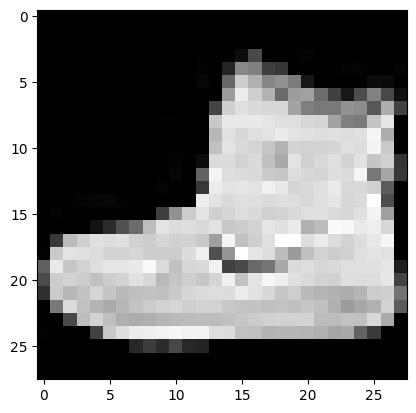

In [14]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(x_train[0], 28)));

This is the fourth image, which should be a dress as per the labels above:

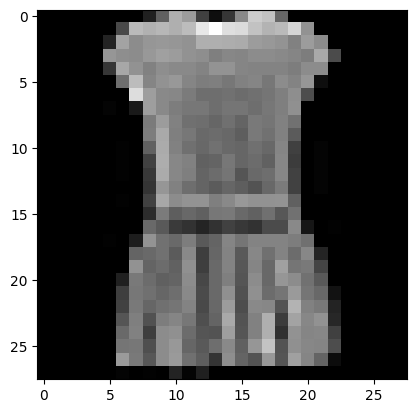

In [15]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(x_train[3], 28)));

Everything looks good!

# Chunking with iterators and generators

I promised I'd return to the `chunks` function defined above. There's a way to define it in a simpler fashion without using generators that goes something like this:

In [16]:
def chunks(x, size):
    result = []
    for i in range(0, len(x), size):
        subarray = x[i:i + size]
        result.append(subarray)
    return result

Functionally this does almost the same thing as what we have above, but this simpler version is less ideal because we're iteratively building up our array in memory on the fly.

The advantage of using a generator (which we create when we use `yield`) is that it only grabs the number of items we need at once, so it's far more memory efficient. (In other words, instead of grabbing all 60,000 images at once, we only make one image (i.e. 784 items / pixels) available at any one time.) With our generator, we can see the next set of items by calling `next` until we reach a `StopIterationError`.

In our implementation, we don't get so many of those benefits since we're still going to store everything in memory anyway. We wrap all our chunk generator functions in `list()` which causes the interpreter to unfurl or unwrap our chunks into an array of arrays.

# Define a matrix class

In standard Python if we want to index into one of our array image we'd normally have to do something like `image[0][15]` whereas in machine learning we generally prefer to do something like `image[0, 15]`. So our next step in manually implementing these things would be to create a `Matrix` class that allows us to do this.

In [17]:
class Matrix:
    def __init__(self, vals):
        self.vals = vals
        
    def __getitem__(self, vals):
        return self.vals[vals[0]][vals[1]]

In [18]:
img = list(chunks(x_train[3], 28))
Matrix(img)[0, 10], img[0][10]

(175, 175)

Now we have a function that does what we want. You can see we used the built-in `__getitem__` function which we over-wrote. This is what Python uses under the hood when you use square brackets to get values from an array, so by overwriting it we can achieve the behaviour we're looking for.

In reality, this implementation probably leaves a bit to be desired, so now that we've implemented it from scratch, we can discard our own version and just use a `tensor` object from PyTorch:

In [19]:
import torch
from torch import tensor

In [20]:
t = tensor(list(chunks(x_train[3], 28)))
t.shape

torch.Size([28, 28])

Now that we know it works, we can map all our values and turn them into tensor objects.

In [21]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
x_train.shape

torch.Size([60000, 784])

As mentioned above, using tensors comes with a bunch of extra benefits.

# Find the shape, min and max values

Our `x_train` is in the shape [60000, 784] and our y_train is just 60,000 individual values. So we still need to chunk our images into 28x28 matrices.

In [22]:
y_train.shape

torch.Size([60000])

For the chunking process, instead of our own function we can use PyTorch's `reshape` method. Note that we pass in the desired new shape, so in our case that could be `(60000,28,28)`. It is more common, however, to use and see the number -1 for the first value, which implies that PyTorch should figure out what the value for that first dimension should be. In our case, we have 60,000 items so that's how big it should be and these two options are both equivalent.

In [23]:
# train_imgs = x_train.reshape((60000,28,28))
train_imgs = x_train.reshape((-1,28,28))
train_imgs.shape

torch.Size([60000, 28, 28])

We can find out the minimum and maximum value found inside one of our images by using Python's `min`, but this is an inbuilt method on the tensor object as well so we can use that now:

In [24]:
train_imgs[0].min(), train_imgs[0].max()

(tensor(0), tensor(255))

As expected, our pixel values represent the 256 shades of grey available. Our labels represent the 10 possible clothing types listed above, so we'd expect our minimum and maximum to be zero and nine respectively:

In [25]:
y_train.min(), y_train.max()

(tensor(0), tensor(9))

# Generate some random numbers

We finished out the lesson with a brief discussion of random number generators, how to implement them and how this might be important for deep learning work. As we learned, there is no way for computers to generate truly random numbers. People go to interesting lengths to create their own random numbers, such as [the infamous lava lamp wall](https://www.cloudflare.com/en-gb/learning/ssl/lava-lamp-encryption/) at Cloudflare, but we are left with being able to create only pseudo-random numbers.

In the class we see a way based on the Wichmann Hill algorithm used before Python 2.3, which goes as follows:

In [33]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1

def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

We have two functions. It's important to note that the `seed` is an important part of these pseudo-random number generators. The seed gives us a number that our generator starts with. Note also how we use global state to store the `rnd_state` variable, and how we are continually updating our values in that state as we generate. Also note that the process of generating the values is fairly simple, but also eminently reproducible.

In [34]:
seed(2349873456787298) # some number I came up with by mashing my keyboard numbers
rnd_state

(24775, 23862, 14675)

In [35]:
rand(),rand(),rand()

(0.6580068826155674, 0.669616116835976, 0.9249613879702964)

We now have a function which generates pseudo-random numbers, but as we'll see, it's not the fastest bit of code around...

# Profile our code

Python has a handy [`timeit` module](https://docs.python.org/3/library/timeit.html) which allows you to calculate how long your code takes to run. What's more, it'll run your code hundreds or thousands of times to get average run times. Here we can see how fast our pseudo-random number generator takes to run, on average:

In [36]:
%timeit -n 10 list(chunks([rand() for _ in range(7840)], 10))

4.05 ms ± 500 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


If we compare it against PyTorch's random number generator, we can see a distinct difference, however:

In [37]:
%timeit -n 10 torch.randn(784,10)

56.1 µs ± 23.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now we're talking about microseconds vs miliseconds, which is a big difference, so we should probably stick to how PyTorch does it.

In [52]:
torch.randn??

Docstring:
randn(*size, *, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) -> Tensor

Returns a tensor filled with random numbers from a normal distribution
with mean `0` and variance `1` (also called the standard normal
distribution).

.. math::
    \text{out}_{i} \sim \mathcal{N}(0, 1)

The shape of the tensor is defined by the variable argument :attr:`size`.

Args:
    size (int...): a sequence of integers defining the shape of the output tensor.
        Can be a variable number of arguments or a collection like a list or tuple.

Keyword args:
    generator (:class:`torch.Generator`, optional): a pseudorandom number generator for sampling
    out (Tensor, optional): the output tensor.
    dtype (:class:`torch.dtype`, optional): the desired data type of returned tensor.
        Default: if ``None``, uses a global default (see :func:`torch.set_default_tensor_type`).
    layout (:class:`torch.layout`, optional): the desired layout of returned Tensor.
     

PyTorch has [an interesting document entitled 'Reproducibility'](https://pytorch.org/docs/stable/notes/randomness.html) in which they state the things that you can try to do to make your code as non-deterministic (i.e. non-random) as possible. This is important if you want to be able to reproduce your work. At the top, however, and as I learned during the Sunday Delft FastAI Study Group discussion, it's not as simple as setting seed values; sometimes even the hardware used needs to be identical in order to achieve reproducibility:

> "Completely reproducible results are not guaranteed across PyTorch releases, individual commits, or different platforms. Furthermore, results may not be reproducible between CPU and GPU executions, even when using identical seeds."

But why do we care about random values in deep learning to start with? We care because we are often doing things like augmentations in parallel. Augmentations are randomly generated, so if all the parallel processes use the same random number sequences then all the processes will generate the same augmented images.

We saw the nice example in the lesson of how our function runs into exactly this problem:

In [53]:
if os.fork():
    print(f'In parent: {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.17354408428968426
In child: 0.17354408428968426


We create two forked processes, which are identical copies of each other. Then we call our pseudo-random number generator. You would expect that these two values would be different, but because we've copied the entire state then we get identical values. What we'd need to do is to set a new seed at the beginning of each process.

In [54]:
if os.fork():
    seed(0)
    print(f'In parent: {rand()}')
else:
    seed(1)
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.01693090619965683
In child: 0.02258025041320865


# "Things Jeremy says to do"

I thought I'd gather some of the core 'things Jeremy says to do' comments from the video lecture for this part of the lecture.

- show the function signature with `shift-Tab`
- use `?` and `??` at the end of a method or function to show the docs and the source code respectively
- read all the docs for every Python function you use
    - look at all the arguments it takes
    - practice with that function inside a notebook
- (sometimes) read the full source code
- pause the video when something in Jeremy's code is unfamiliar and experiment around with it in a notebook
    - read the docs and example code for those new concepts
- (at some point) read through all the docs for the `Tensor` object / concept

Note that there's a bit more when it comes to the imagic demonstration which I'll try to cover in a separate blogpost.

In any case, there was a lot in this lecture. This week is all about matrix multiplication which I'm looking forward to getting to implement myself!